# Week of 2025.07.21

## Last week
[Last week](https://paxtonsc.github.io/files/geophysics/volcano_project/weekly_notes/2025.07.16.infrasound.html) I looked into the diffusive error that we saw at the slip/atmosphere boundary. My conclusions from last week were the following. 

1. When we reduce the spatial discretization size to 0.1m, the velocity and slip graphs with atmosphere largely match the model with out atmosphere (which also roughly matches the lumped parameter model). However, even with 0.1m spacing we still can see a significant increase in density (and resulting decrease in sound speed) at the base of the 1D atmosphere. 

2. When we start the simulation at 2s (with the first 2s simulation without atmosphere), a `1m` discretization achieves a similar "accuracy" with the 0.1 m and atmosphere included for the full length of the simulation. 

3. For simulations without atmosphere, modeling the atmosphere as a constant 1e5 Pa likely results in incorrect pressure near the outlet. 

## High level goal
Let's remember, our high level goal is to create an accurate infrasound model of the eruption in a 2D mesh.

## Problems
Let's also review our problems, proceeding from general to specific.
1. When we model the 2D infrasound we get a result that is hard to validate.
2. When we simplify the problem to a toy model (with only gravity, sip weakening, viscous friction, and pressure) we see that pairing the atmosphere results in significant numerical diffusion. 

## Plan 
1. Let's first verify that with this toy problem, when we increase the resolution sufficiently we are able to generate results (conduit model + 1D atmosphere model) that can be validated by (a) lumped parameter model for the melt (b) simple relation between pressure and velocity $\Delta p = \rho c \Delta v$. 

2. Once that is done, let's try to model the toy problem with a 2D mesh field for the atmosphere. We would like similarly show that the the melt is still accurately represented by the lumped parameter model and that the 2D atmosphere is accurately modeled by a monopole source term. 

## Goals 
- [] Model toy example with  0.01m order 1 atmosphere. Check to see if that resolves the diffusion issue. 
- [] Write a new animation class to display both the melt and the atmosphere in a single simulation. 
- [] Attach the updated conduit flow model to the 1D atmosphere. Simulate with 0.1m accuracy and see how much numerical diffusion is happening. Compare result with analytical solution that just related pressure and velocity. 
- [] Return to 2D model of toy problem. Remind yourself of how close the 1D monopole source is. 


## Review of size of mesh and numerical diffusion. 

Let's start by reviewing the size of the mesh and the relationship with numerical diffusion from last week. 

In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func, get_quantities_at_conduit_exit, get_quantities_at_all_space
from helper_code.animate import animate_conduit_pressure, animate_melt_atmosphere_combination
from helper_code.analytical_solution import get_lumped_solution

import helper_code.infrasound as infrasound
from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'

folder_name = "simple_conduit"

ITERS = 50
D_ITERS = 1
END_TIME = 10
C0 = 320 # m/s at 5000m

In [29]:
t_analytical, slip_analytical, u_analytical = get_lumped_solution(
    K=1e9,
    L_melt=950,
    tau_p=1e6,
    tau_r=0,
    R=10,
    L_plug=50,
    rho=2.6e3,
    mu=5e4,
    D_c=3,
    C=600,
    p0=11.5e6,
    p_atm=1e5,
    t_end=10
)

file_name = "short_plug_v0"
folder_name = "simple_conduit_1d_atmosphere"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_quail_w_atm, p_quail_w_atm, slip_quail_w_atm, u_quail_w_atm, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)

file_name = "short_plug_v1"
folder_name = "simple_conduit_1d_atmosphere"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_quail_w_atm_1, p_quail_w_atm_1, slip_quail_w_atm_1, u_quail_w_atm_1, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)

file_name = "short_plug_v2"
folder_name = "simple_conduit_1d_atmosphere"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_quail_w_atm_2, p_quail_w_atm_2, slip_quail_w_atm_2, u_quail_w_atm_2, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)

file_name = "short_plug_1m"
folder_name = "simple_conduit_no_atmosphere"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_quail, p_quail, slip_quail, u_quail, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)

file_name = "order1_atm_01m"
folder_name = "simple_conduit_1D_atmosphere_linear_IC"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_quail_order1_01m, p_quail_order1_01m, slip_quail_order1_01m, u_quail_order1_01m, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=7, compute_temp=True, conduit_index=-1
)

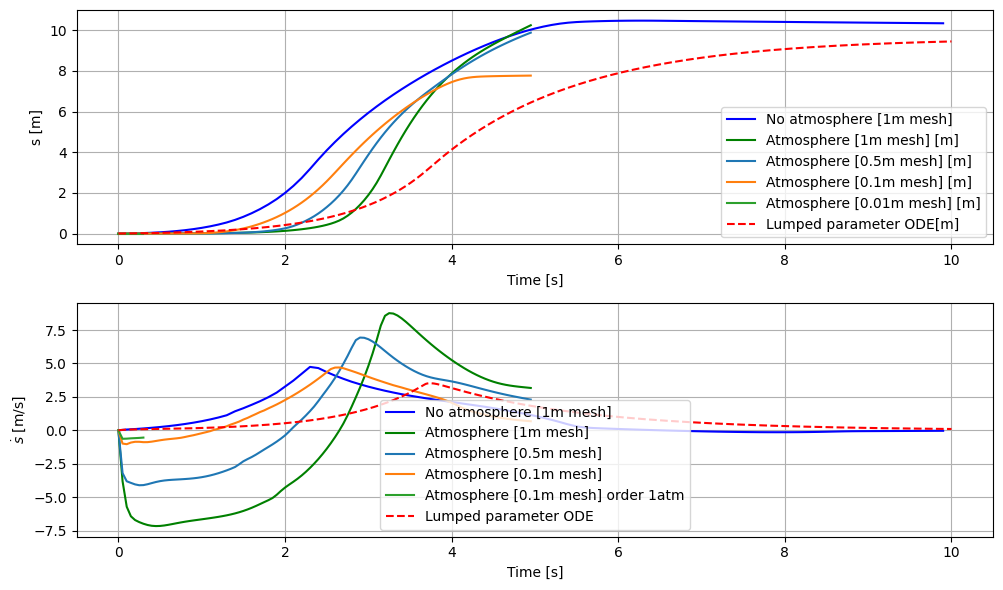

In [30]:
# Plot results
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(t_quail, slip_quail, "b-", label="No atmosphere [1m mesh]")
plt.plot(t_quail_w_atm, slip_quail_w_atm, "g-", label="Atmosphere [1m mesh] [m]")
plt.plot(t_quail_w_atm_1, slip_quail_w_atm_1, label="Atmosphere [0.5m mesh] [m]")
plt.plot(t_quail_w_atm_2, slip_quail_w_atm_2, label="Atmosphere [0.1m mesh] [m]")
plt.plot(t_quail_order1_01m, slip_quail_order1_01m, label="Atmosphere [0.01m mesh] [m]")
plt.plot(t_analytical, slip_analytical, "r--", label="Lumped parameter ODE[m]")
plt.xlabel("Time [s]")
plt.ylabel("s [m]")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t_quail, u_quail, "b-", label="No atmosphere [1m mesh]")
plt.plot(t_quail_w_atm, u_quail_w_atm, "g-", label="Atmosphere [1m mesh]")
plt.plot(t_quail_w_atm_1, u_quail_w_atm_1, label="Atmosphere [0.5m mesh]")
plt.plot(t_quail_w_atm_2, u_quail_w_atm_2, label="Atmosphere [0.1m mesh]")
plt.plot(t_quail_order1_01m, u_quail_order1_01m, label="Atmosphere [0.1m mesh] order 1atm")
plt.plot(t_analytical, u_analytical, "r--", label="Lumped parameter ODE")
plt.xlabel("Time [s]")
plt.ylabel(r"$\dot{s}$ [m/s]")
plt.grid(True)
plt.legend()

plt.savefig(f"{BASE_PATH}/volcano_sims/notebooks/charts/lumped_parameter_model.png")
plt.tight_layout()
plt.show()

## Review full simulation of high spatial fidelity simulation of melt + atmosphere 

Let's review the behavior of the melt + atmosphere in the model with 0.1m spatial resolution. Note, that we only track slip in the melt, so there is not slip observed in the atmosphere. 

In [42]:
folder_name = "simple_conduit_1D_atmosphere_linear_IC"
melt_file_name = "short_plug_order1_atm_1m"
atmosphere_file_name = "vertical_atmosphere_01_atm1"
melt_solver_func = get_local_solver_from_index_func(folder_name, melt_file_name)
atmosphere_solver_func = get_local_solver_from_index_func(folder_name, atmosphere_file_name)

iters = 100

ani = animate_melt_atmosphere_combination(
    melt_solver_func,
    atmosphere_solver_func,
    iterations=100,
    d_iterations=10,
    y_min=-1000,
    y_max=1000,
    max_pressure=0.2,
    min_pressure=0,
    max_velocity=10,
    min_velocity=0,
    max_density=3e3,
    min_density=0,
    max_slip=20,
    min_slip=0,
)

HTML(ani.to_html5_video())